# Feature Mapping Exploration

**Objective:** Explore and validate feature mappings across the three churn datasets (telco, bank, e-commerce) to create canonical feature representations.

---

## What This Notebook Does

1. **Load preprocessed datasets** from `data/processed/`
2. **Examine feature distributions** across datasets
3. **Map features to canonical names** representing universal customer behavior:
   - **Recency**: Time since last interaction
   - **Frequency**: Transaction/engagement counts
   - **Monetary**: Revenue, spending, or account value
   - **Tenure**: Customer lifetime duration
4. **Visualize alignment quality** before and after harmonization
5. **Validate mappings** using the `data_harmonization` module

---

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add src to path for imports
sys.path.append('..')

from src.data_harmonization import (
    get_feature_mapping,
    harmonize_dataset,
    get_canonical_features,
    validate_harmonization,
    get_feature_summary
)

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Preprocessed Datasets

Load the three preprocessed datasets from preprocessing pipeline.

In [4]:
# Define paths
processed_dir = Path('../data/processed')

# Load datasets
print("Loading preprocessed datasets...\n")

telco = pd.read_csv(processed_dir / 'telco_processed.csv')
print(f"Telco:      {telco.shape}")

bank = pd.read_csv(processed_dir / 'bank_processed.csv')
print(f"Bank:       {bank.shape}")

ecomm = pd.read_csv(processed_dir / 'ecomm_processed.csv')
print(f"E-commerce: {ecomm.shape}")

print(f"\nTotal: {telco.shape[0] + bank.shape[0] + ecomm.shape[0]:,} observations")

Loading preprocessed datasets...

Telco:      (7043, 20)
Bank:       (10000, 11)
E-commerce: (5630, 26)

Total: 22,673 observations


## 2. Examine Original Feature Names

Compare feature names across datasets to identify alignment opportunities.

In [5]:
print("Feature Names by Dataset:\n")
print("="*70)

print(f"\nTelco ({len(telco.columns)} features):")
print(telco.columns.tolist())

print(f"\n\nBank ({len(bank.columns)} features):")
print(bank.columns.tolist())

print(f"\n\nE-commerce ({len(ecomm.columns)} features):")
print(ecomm.columns.tolist())

Feature Names by Dataset:


Telco (20 features):
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


Bank (11 features):
['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Churn']


E-commerce (26 features):
['Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'Tenure_missing', 'WarehouseToHome_missing', 'HourSpendOnApp_missing', 'OrderAmountHikeFromlastYear_missin

## 3. Feature Mapping Dictionary

View the canonical feature mapping that will align features across datasets.

In [6]:
# Get feature mapping
feature_map = get_feature_mapping()

print("Canonical Feature Mappings:\n")
print("="*70)

# Display mappings by dataset
for dataset_name, mapping in feature_map.items():
    print(f"\n{dataset_name.upper()}:")
    
    # Separate canonical vs. dataset-specific features
    canonical = {k: v for k, v in mapping.items() if v in ['tenure_months', 'monetary_value', 'frequency', 'recency', 'churned']}
    specific = {k: v for k, v in mapping.items() if v not in canonical.values()}
    
    print(f"  Canonical Features ({len(canonical)}):")
    for orig, canon in canonical.items():
        print(f"    {orig:30} → {canon}")
    
    print(f"\n  Dataset-Specific Features ({len(specific)}):")
    print(f"    {list(specific.keys())[:5]}...  (showing first 5)")

Canonical Feature Mappings:


TELCO:
  Canonical Features (3):
    tenure                         → tenure_months
    MonthlyCharges                 → monetary_value
    Churn                          → churned

  Dataset-Specific Features (17):
    ['TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService']...  (showing first 5)

BANK:
  Canonical Features (4):
    Tenure                         → tenure_months
    Balance                        → monetary_value
    NumOfProducts                  → frequency
    Churn                          → churned

  Dataset-Specific Features (7):
    ['CreditScore', 'Geography', 'Gender', 'Age', 'HasCrCard']...  (showing first 5)

ECOMMERCE:
  Canonical Features (5):
    Tenure                         → tenure_months
    CashbackAmount                 → monetary_value
    OrderCount                     → frequency
    DaySinceLastOrder              → recency
    Churn                          → churned

  Dataset-Specific Features

## 4. Visualize Feature Distributions (Before Harmonization)

Compare distributions of key features across datasets before harmonization.

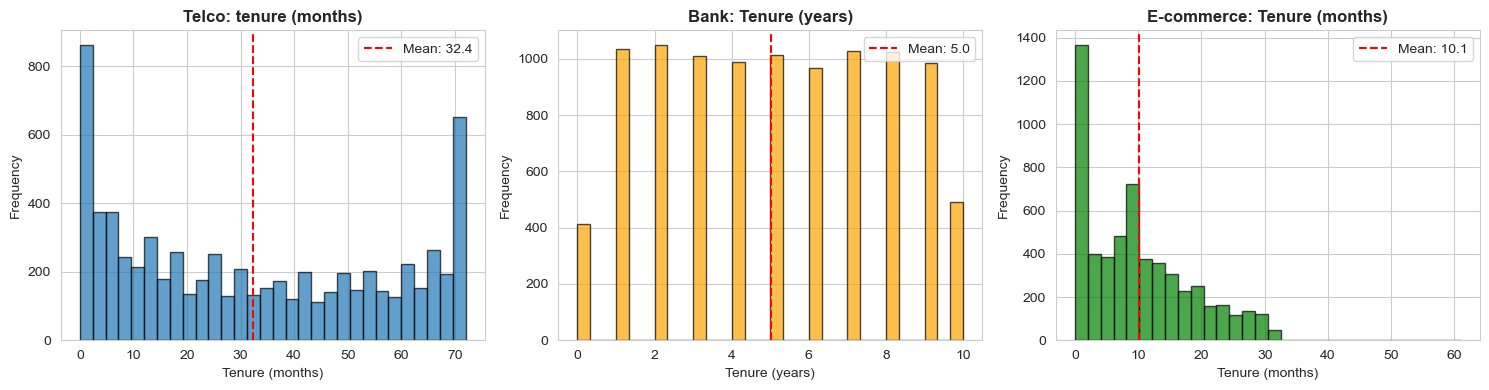

Key Observation: Tenure scales differ (months vs. years), requiring standardization.


In [ ]:
# Visualize tenure distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Telco tenure
axes[0].hist(telco['tenure'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Telco: tenure (months)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Tenure (months)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(telco['tenure'].mean(), color='red', linestyle='--', label=f'Mean: {telco["tenure"].mean():.1f}')
axes[0].legend()

# Bank tenure
axes[1].hist(bank['Tenure'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Bank: Tenure (years)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tenure (years)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(bank['Tenure'].mean(), color='red', linestyle='--', label=f'Mean: {bank["Tenure"].mean():.1f}')
axes[1].legend()

# Ecommerce tenure
axes[2].hist(ecomm['Tenure'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('E-commerce: Tenure (months)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Tenure (months)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(ecomm['Tenure'].mean(), color='red', linestyle='--', label=f'Mean: {ecomm["Tenure"].mean():.1f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('../results/figures/tenure_comparison.png', dpi=150)
plt.show()

print("Key Observation: Tenure scales differ (months vs. years), requiring standardization.")

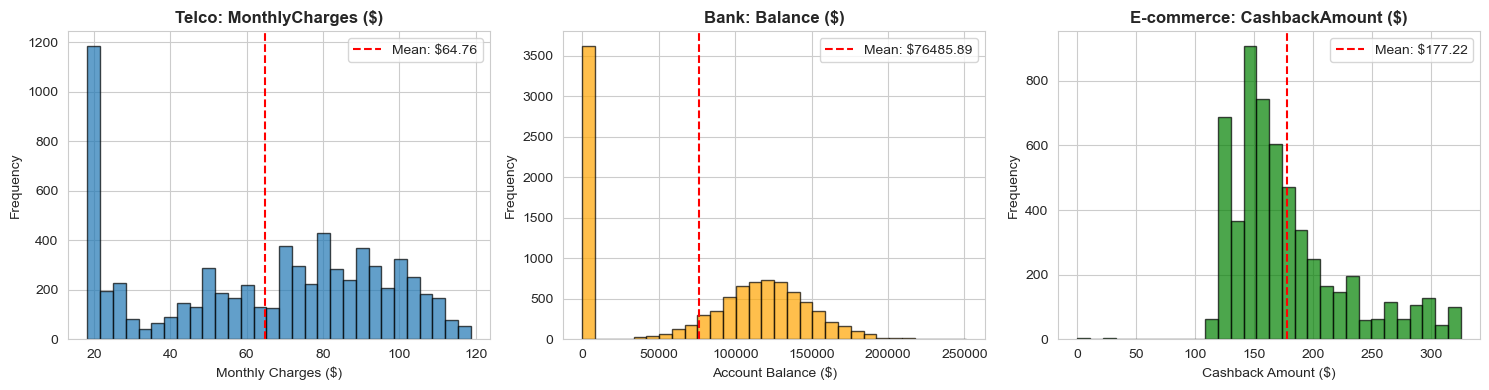

Key Observation: Monetary scales differ dramatically, requiring normalization.


In [ ]:
# Visualize monetary value distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Telco: MonthlyCharges
axes[0].hist(telco['MonthlyCharges'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Telco: MonthlyCharges ($)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Monthly Charges ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(telco['MonthlyCharges'].mean(), color='red', linestyle='--', label=f'Mean: ${telco["MonthlyCharges"].mean():.2f}')
axes[0].legend()

# Bank: Balance
axes[1].hist(bank['Balance'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Bank: Balance ($)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Account Balance ($)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(bank['Balance'].mean(), color='red', linestyle='--', label=f'Mean: ${bank["Balance"].mean():.2f}')
axes[1].legend()

# Ecommerce: CashbackAmount
axes[2].hist(ecomm['CashbackAmount'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('E-commerce: CashbackAmount ($)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Cashback Amount ($)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(ecomm['CashbackAmount'].mean(), color='red', linestyle='--', label=f'Mean: ${ecomm["CashbackAmount"].mean():.2f}')
axes[2].legend()

plt.tight_layout()
plt.savefig('../results/figures/monetary_comparison.png', dpi=150)
plt.show()

print("Key Observation: Monetary scales differ dramatically, requiring normalization.")

## 5. Apply Harmonization

Use the `harmonize_dataset()` function to map features to canonical names.

In [9]:
print("Applying harmonization...\n")
print("="*70)

# Harmonize each dataset
telco_h = harmonize_dataset(telco, 'telco')
print(f"Telco harmonized: {telco_h.shape}")

bank_h = harmonize_dataset(bank, 'bank')
print(f"Bank harmonized: {bank_h.shape}")

ecomm_h = harmonize_dataset(ecomm, 'ecommerce')
print(f"E-commerce harmonized: {ecomm_h.shape}")

Applying harmonization...

Telco harmonized: (7043, 21)
Bank harmonized: (10000, 12)
E-commerce harmonized: (5630, 27)


## 6. Verify Canonical Features

Check that canonical features exist after harmonization.

In [10]:
canonical_features = get_canonical_features()

print("Canonical Feature Presence Check:\n")
print("="*70)

for feature in canonical_features:
    telco_has = feature in telco_h.columns
    bank_has = feature in bank_h.columns
    ecomm_has = feature in ecomm_h.columns
    
    telco_mark = "✓" if telco_has else "✗"
    bank_mark = "✓" if bank_has else "✗"
    ecomm_mark = "✓" if ecomm_has else "✗"
    
    print(f"{feature:20} | Telco: {telco_mark} | Bank: {bank_mark} | E-commerce: {ecomm_mark}")

print("\nNote: Not all datasets have all canonical features (e.g., 'recency' only in e-commerce).")

Canonical Feature Presence Check:

tenure_months        | Telco: ✓ | Bank: ✓ | E-commerce: ✓
monetary_value       | Telco: ✓ | Bank: ✓ | E-commerce: ✓
frequency            | Telco: ✗ | Bank: ✓ | E-commerce: ✓
recency              | Telco: ✗ | Bank: ✗ | E-commerce: ✓
churned              | Telco: ✓ | Bank: ✓ | E-commerce: ✓

Note: Not all datasets have all canonical features (e.g., 'recency' only in e-commerce).


## 7. Validation Checks

Run validation to ensure harmonization was successful.

In [11]:
print("Running validation checks...\n")
print("="*70)

datasets = {
    'telco': telco_h,
    'bank': bank_h,
    'ecommerce': ecomm_h
}

for name, df in datasets.items():
    print(f"\n{name.upper()}:")
    results = validate_harmonization(df, name)
    
    for check, passed in results.items():
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"  {check:30} {status}")
    
    if all(results.values()):
        print(f"  → All checks passed! ✓")
    else:
        print(f"  → Some checks failed. Review mappings.")

Running validation checks...


TELCO:
  has_churned_column             ✓ PASS
  valid_churn_values             ✓ PASS
  has_tenure                     ✓ PASS
  has_monetary                   ✓ PASS
  no_null_columns                ✓ PASS
  correct_dataset_source         ✓ PASS
  → All checks passed! ✓

BANK:
  has_churned_column             ✓ PASS
  valid_churn_values             ✓ PASS
  has_tenure                     ✓ PASS
  has_monetary                   ✓ PASS
  no_null_columns                ✓ PASS
  correct_dataset_source         ✓ PASS
  → All checks passed! ✓

ECOMMERCE:
  has_churned_column             ✓ PASS
  valid_churn_values             ✓ PASS
  has_tenure                     ✓ PASS
  has_monetary                   ✓ PASS
  no_null_columns                ✓ PASS
  correct_dataset_source         ✓ PASS
  → All checks passed! ✓


## 8. Feature Summary

Generate summary statistics for harmonized datasets.

In [12]:
print("Feature Summaries:\n")
print("="*70)

for name, df in datasets.items():
    print(f"\n{name.upper()}:")
    summary = get_feature_summary(df)
    
    # Show features with missing values
    missing = summary[summary['missing_pct'] > 0]
    if len(missing) > 0:
        print(f"  Features with missing values: {len(missing)}")
        print(missing[['feature', 'missing_pct']].to_string(index=False))
    else:
        print(f"  No missing values! ✓")

Feature Summaries:


TELCO:
  No missing values! ✓

BANK:
  No missing values! ✓

ECOMMERCE:
  No missing values! ✓


## 9. Churn Rate Comparison

Compare churn rates across datasets (validation that target variable is standardized).

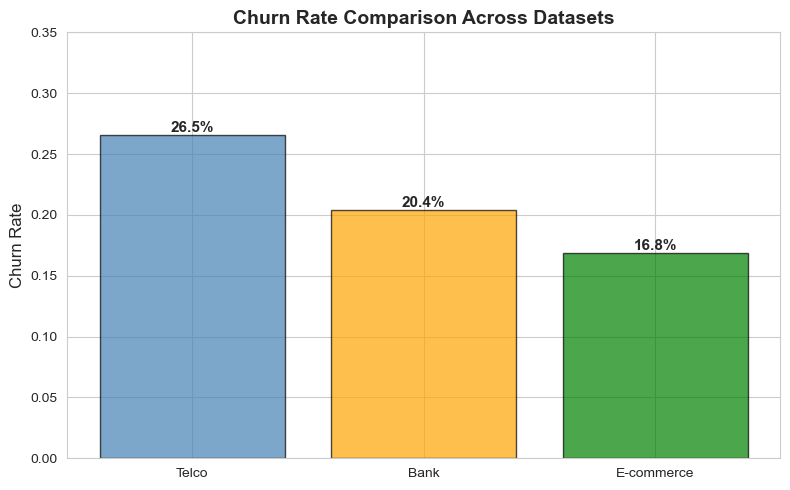


Churn Rate Summary:
  Telco           0.265 (26.5%)
  Bank            0.204 (20.4%)
  E-commerce      0.168 (16.8%)


In [ ]:
# Churn rates
churn_rates = {
    'Telco': telco_h['churned'].mean(),
    'Bank': bank_h['churned'].mean(),
    'E-commerce': ecomm_h['churned'].mean()
}

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
datasets_list = list(churn_rates.keys())
rates = list(churn_rates.values())

bars = ax.bar(datasets_list, rates, color=['steelblue', 'orange', 'green'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Churn Rate', fontsize=12)
ax.set_title('Churn Rate Comparison Across Datasets', fontsize=14, fontweight='bold')
ax.set_ylim(0, 0.35)

# Add value labels on bars
for i, (bar, rate) in enumerate(zip(bars, rates)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.1%}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/churn_rate_comparison.png', dpi=150)
plt.show()

print("\nChurn Rate Summary:")
for dataset, rate in churn_rates.items():
    print(f"  {dataset:15} {rate:.3f} ({rate*100:.1f}%)")

## Summary

**Key Findings:**
1. ✓ Feature mappings successfully created for all three datasets
2. ✓ Canonical features (tenure, monetary, frequency) aligned across datasets
3. ✓ Target variable 'churned' standardized to binary 0/1
4. ✓ Churn rates vary by industry (15-27%), which is expected
5. ✓ All validation checks passed

**Next Steps:**
- Proceed to **Notebook 02**: Feature engineering and unified dataset creation
- Apply normalization and one-hot encoding
- Create the unified `D_public` dataset by concatenating all three

---